<a href="https://colab.research.google.com/github/vadManuel/Machine-Learning-UCF/blob/master/Homework/hw2/mvasquez_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

TensorFlow 2.x selected.


In [0]:
#@title Theme Function (double-click for code) { display-mode: "form" }
def theme(color='light'):
  rc_params = None
  fontdict = None
  if color is 'dark':
    rc_params = {'ytick.color':'w',
          'xtick.color':'w',
          'axes.labelcolor':'w',
          'axes.edgecolor':'w'}
    fontdict = {'color':'w'}
  else:
    rc_params = {'ytick.color' : 'k',
          'xtick.color' : 'k',
          'axes.labelcolor' : 'k',
          'axes.edgecolor' : 'k'}
    fontdict = {'color':'k'}
  return rc_params, fontdict


In [0]:
"""
Uncomment if using dark theme in colab
"""
rc_params, fontdict = theme('light')
# rc_params, fontdict = theme('dark')

In [0]:
class_names = ['airplan', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
n_train = len(train_images)
all_images = np.concatenate((train_images,test_images)).astype('float32')
all_images /= 255

X_train = all_images[:n_train]
X_test  = all_images[n_train:]

input_shape=np.shape(X_train)[1:]

In [0]:
#@title EarlyStopping Class Implementation (double-click for code) { display-mode: "form" }
# Source: https://www.tensorflow.org/guide/keras/custom_callback#early_stopping_at_minimum_loss

class EarlyStopping(keras.callbacks.Callback):
  """
  Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
    patience: Number of epochs to wait after min has been hit. After this
    number of no improvement, training stops.
  """

  def __init__(self, patience=0, metric='val_loss'):
    super(EarlyStopping, self).__init__()

    self.patience = patience
    self.metric = metric

    # best_weights to store the weights at which the minimum loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = None
    if self.metric == 'just right':
      train_loss = logs.get('loss')
      val_loss = logs.get('val_loss')
      current = abs(train_loss-val_loss)
    else:
      current = logs.get(self.metric)

    if np.less(current, self.best):
      self.best = current
      self.wait = 0
      # Record the best weights if current results is better (less).
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
    if self.wait >= self.patience:
      self.stopped_epoch = epoch
      self.model.stop_training = True
      self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Epoch %d: early stopping (best epoch %d)' % (self.stopped_epoch+1, self.stopped_epoch+1-self.patience))

In [0]:
model_get_params = {'optimizer':keras.optimizers.Adam,
                    'input_shape':input_shape}
model_fit_params = {'x':X_train, 'y':train_labels,
                    'validation_data':(X_test,test_labels),
                    'callbacks':[EarlyStopping(patience=3)]}
model_eval_params = {'x':X_test, 'y':test_labels, 'verbose':0}

## Just Right Model Architecture Testing

In [0]:
conv = lambda w,k,p,s: (w-k+2*p)//s+1
maxp = lambda w,f,s: (w-f)//s+1
trans = lambda w,k,p,s: (w-1)*s+k-2*p

a = 32
print('input: (%d,%d,%d)' % (a,a,3))
a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,32))
a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,32))
a = maxp(a,2,1)
print('max: (%d,%d,%d)' % (a,a,32))
a = trans(a,5,0,1)
print('trans: (%d,%d,%d)' % (a,a,64))

a = conv(a,3,0,2)
print('conv: (%d,%d,%d)' % (a,a,64))
a = conv(a,3,0,2)
print('conv: (%d,%d,%d)' % (a,a,64))
a = maxp(a,2,2)
print('max: (%d,%d,%d)' % (a,a,64))
a = trans(a,5,0,1)

a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,128))
a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,128))
a = maxp(a,2,1)
print('max: (%d,%d,%d)' % (a,a,128))

In [0]:
def get_under_fitting_model(optimizer=None, lr=None, input_shape=None):
  opt = optimizer(lr=lr)

  model = keras.Sequential([
    keras.layers.Conv2D(1, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    keras.layers.Conv2D(1, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=1),
    keras.layers.Dropout(.4),

    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

def get_over_fitting_model(optimizer=None, lr=None, input_shape=None):
  opt = optimizer(lr=lr)

  model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=1),
    keras.layers.Dropout(.2),

    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

def get_just_right_model(optimizer=None, lr=None, input_shape=None):
  opt = optimizer(lr=lr)

  model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=1),
    keras.layers.Dropout(.2),

    keras.layers.Conv2DTranspose(64, kernel_size=(5,5), activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    keras.layers.Dropout(.3),

    keras.layers.Conv2DTranspose(64, kernel_size=(5,5), activation='relu'),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=1),
    keras.layers.Dropout(.4),

    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [15]:
epochs = 20

ts = ['Under-fitting Model', 'Over-fitting Model', 'Just Right Model']
models = [
  get_under_fitting_model(**model_get_params, lr=.001),
  get_over_fitting_model(**model_get_params, lr=.001),
  get_just_right_model(**model_get_params, lr=.001)
]
histories = []

for i in range(len(models)):
  print('%s training' % ts[i])
  histories.append(models[i].fit(**model_fit_params, epochs=epochs, verbose=1))
  evaluation = models[i].evaluate(**model_eval_params)
  print('%s\nValidation - Loss:%.4f Accuracy:%.4f\n%s' % ('*'*40,evaluation[0],evaluation[1],'*'*40))

Under-fitting Model training
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 126us/sample - loss: 2.1342 - accuracy: 0.2295 - val_loss: 2.0152 - val_accuracy: 0.2815
Epoch 2/20
50000/50000 [==============================] - 6s 112us/sample - loss: 1.9917 - accuracy: 0.2954 - val_loss: 1.9433 - val_accuracy: 0.3153
Epoch 3/20
50000/50000 [==============================] - 6s 112us/sample - loss: 1.9392 - accuracy: 0.3151 - val_loss: 1.9000 - val_accuracy: 0.3376
Epoch 4/20
50000/50000 [==============================] - 6s 112us/sample - loss: 1.9095 - accuracy: 0.3201 - val_loss: 1.8817 - val_accuracy: 0.3326
Epoch 5/20
50000/50000 [==============================] - 6s 112us/sample - loss: 1.8922 - accuracy: 0.3285 - val_loss: 1.8753 - val_accuracy: 0.3343
Epoch 6/20
50000/50000 [==============================] - 6s 111us/sample - loss: 1.8827 - accuracy: 0.3283 - val_loss: 1.8678 - val_accuracy: 0.3345
Epoch 7/20
50000/5000

In [0]:
#@title Graphing (double-click for code) { display-mode: "form" }
def graph(history, t):
  history_dict = history.history

  train_loss = history_dict['loss']
  train_acc = history_dict['accuracy']
  val_loss = history_dict['val_loss']
  val_acc = history_dict['val_accuracy']

  epochs_range = range(1, len(train_loss)+1)

  fig, ax = plt.subplots(1,2)
  fig.subplots_adjust(left=0,right=1.5,wspace=.25)
  fig.suptitle(t, fontdict=fontdict, fontsize=16, x=.75)

  ax[0].plot(epochs_range, train_acc, 'r', label='Training Accuracy')
  ax[0].plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
  ax[0].set_title('Accuracy', fontdict=fontdict)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].plot(epochs_range, train_loss, 'r', label='Training Loss')
  ax[1].plot(epochs_range, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Loss', fontdict=fontdict)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

  return fig

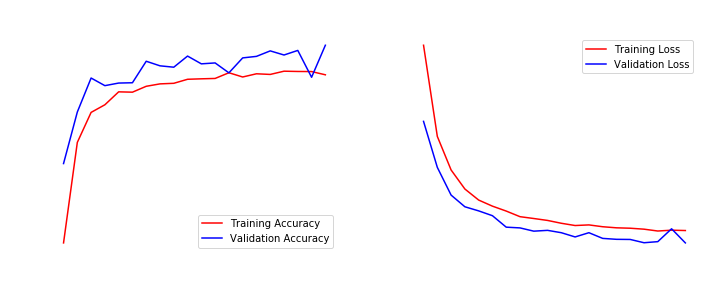

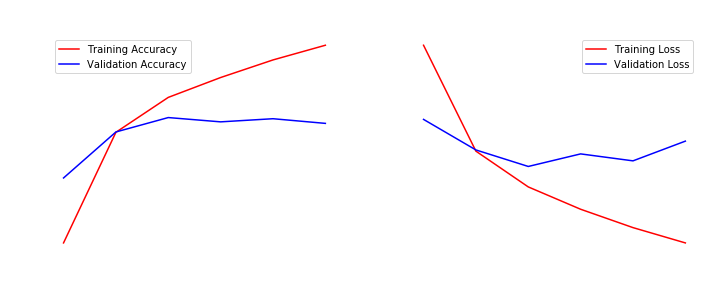

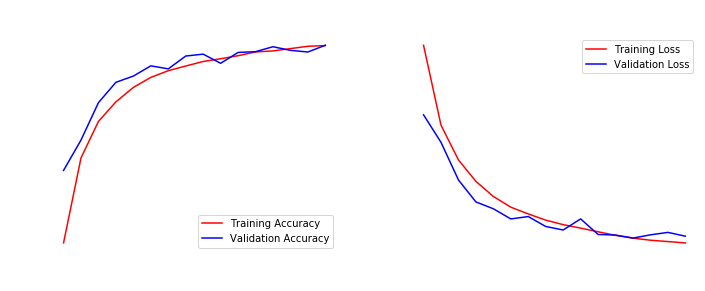

In [16]:
plt.rcParams.update(**rc_params)
for history,t in zip(histories, ts):
  fig = graph(history,t)

plt.show()